In [2]:
import pandas as pd


In [4]:
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')


In [5]:
ratings['label'] = (ratings['rating'] >= 4).astype(int)

In [6]:
data = ratings.merge(books, left_on='book_id', right_on='book_id')

In [7]:
data.columns

Index(['book_id', 'user_id', 'rating', 'label', 'id', 'best_book_id',
       'work_id', 'books_count', 'isbn', 'isbn13', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'image_url', 'small_image_url'],
      dtype='object')

In [8]:
features = ['average_rating', 'ratings_count', 'work_text_reviews_count']

In [9]:
X = data[features].copy()
y = data['label']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
from torch.utils.data import Dataset
import torch

class BookDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
train_dataset = BookDataset(X_train, y_train)
test_dataset = BookDataset(X_test, y_test)


In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024)

In [19]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
epochs = 5
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.view(-1,1).to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.6358
Epoch 2/5, Loss: 0.6355
Epoch 3/5, Loss: 0.6356
Epoch 4/5, Loss: 0.6356
Epoch 5/5, Loss: 0.6356


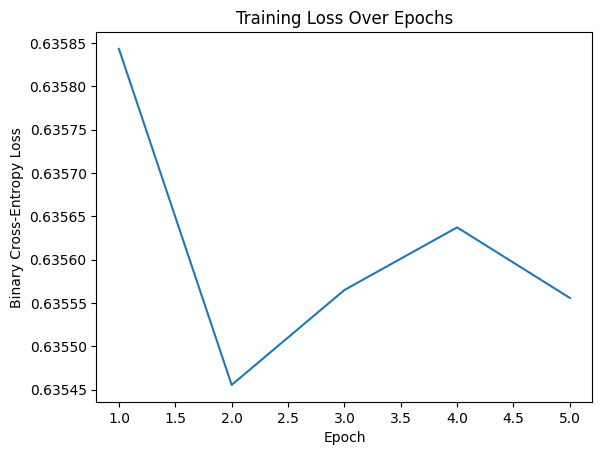

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print(f"Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
print(f"Precision: {precision_score(y_true, y_pred):.3f}")
print(f"Recall:    {recall_score(y_true, y_pred):.3f}")
print(f"F1-score:  {f1_score(y_true, y_pred):.3f}")

Accuracy:  0.665
Precision: 0.667
Recall:    0.994
F1-score:  0.798
